# Result Extraction
### In this notebook we will go through the MU PDF containing semester 7 results and extract them and store them in a pandas DataFrame and then extract the data as a csv. The csv will be further cleaned however that part is not covered in this notebook and can be found here https://www.kaggle.com/code/mizerable/df-cleaning

#### Setting up the notebook

We will be using the PyMuPDF library to read and manipulate our pdf. So we will install it and import it along with pandas for creating DataFrame and re for Regular Expressions.

In [ ]:
!pip install PyMuPDF

In [ ]:
import pandas as pd
import fitz
import re

Now we will read the PDF file into *doc* using PyMuPDF(fitz)

In [ ]:
doc = fitz.open("./data/1T00737.pdf")


Our document can be seprated into different "cells" that are divided by the same string of dashes. We can use this to our advantage and determine where to start collecting data and where to stop. We define a *sep* variable to hold this string

Here you can see the seperator string *sep* seperating the marks of student from other marks and data.
Notice there is another similiar string within the cell but its of smaller size.
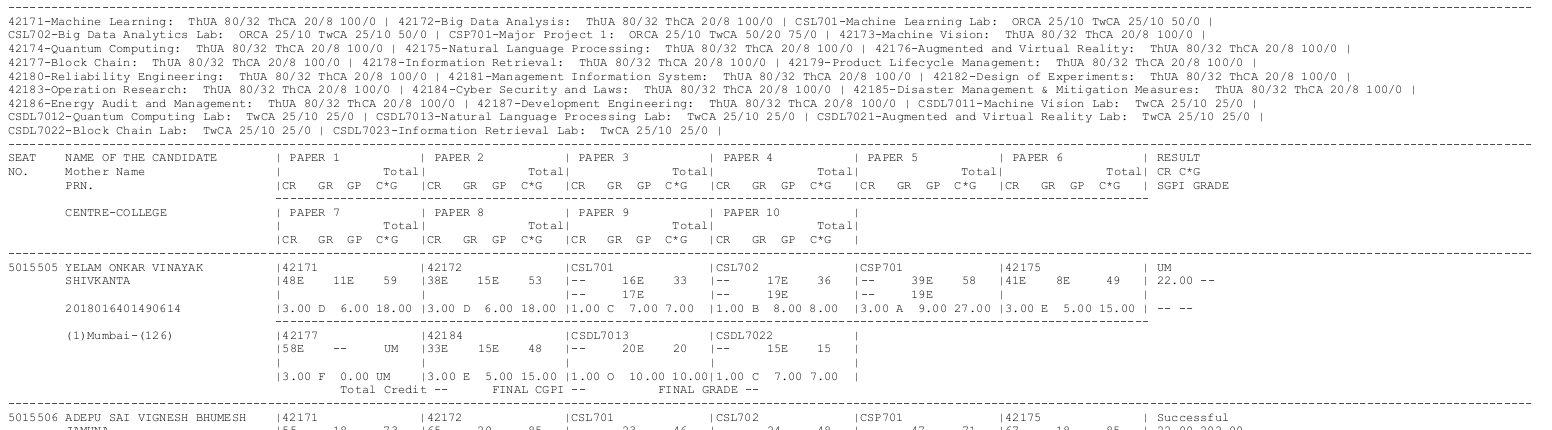

In [ ]:
sep = '-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

Now we will define a function to simply extract the data from one of these cells. 
In order to simplify our task first we will seperate each cell on each page using something like `page.split(sep)`.
We will further seperate the cell by creating a list containing each line of the cell, this will be done with something like `cell.split('\n')` where '\n' represents a newline character.
This list of lines will be the input to our function. 
The reason we are writing this function first instead of the function that will create the cells is because we start from the smallest problem first. Once this problem is solved we can use the function in the overalll function.

Each line of the function simply reads lines that have the relevant data and extracting data from the specified location. All the parameters and regular expressions are based on the data present in the pdf. One main assumption or requirement is that all the lists of lines should be of same format. That is the first element should be empty, the second element is the start of the students data, and the last element is also empty. This is the general format a cell will have using the split function mentioned above.

In [ ]:
def extract_data(text):
    '''
    every block of str for each student is 10 line.
    the fields are 4 lines only but since they continue on the next line also, 4+4 = 8 + 1 line of divider + 1 line of aggregate.
    therefore the line for subject codes are on line 
    '''
    seat_no=re.search(r'[0-9]{7}',text[1]).group(0)
    name = re.search(r'(?:(?:\/\s)?[A-Z]+\s)+',text[1]).group(0)
    sub1_6 = re.findall(r'\|(\S+)',text[1])
    sub7_10 = re.findall(r'\|(\S+)',text[6]) # 5 because thats where the line of subjects continue in the str format
    sub1_10 = sub1_6 + sub7_10
    status = re.search(r'\|.?[a-zA-Z]+(?:\s|$)',text[1]).group(0)
    split_2nd_row = text[2].split('|')
    mother_name = split_2nd_row[0].strip()
    marks1_6 = split_2nd_row[1:7]
    marks7_10 = text[7].split('|')[1:5] # number of marks change so cant repeat previous logic
    marks1_10 = marks1_6 + marks7_10
    agg_marks = split_2nd_row[7]
    split_4th_row = text[4].split('|')
    prn = split_4th_row[0].strip()
    grades1_6= split_4th_row[1:7]
    grades7_10= text[9].split('|')[1:5]
    grades1_10 = grades1_6 +grades7_10
    sgpi = split_4th_row[7]
    centre = (re.search(r'^\s*\S+',text[6]).group(0)).strip()
    
    
    return [seat_no,prn,centre,name,mother_name,sub1_10,marks1_10,agg_marks,grades1_10,sgpi,status]

Now that we have solved the subproblem we will tackle the bigger problem.<br>
As you may have noticed, the pages in the pdf don't align to the pages of the data. This creates an issue for us as some cells will be divided between two pages. Also we don't want to run our *extract_data* function on every cell but on only those that have the relevant data.<br>
For this we will write a function that will first load two consecutive pages, this is so that we can extract the data that is split between two pages.
We will then create cells using the *split* function. <br>
And then for each cell we will check if the length of the cell is equal to 12. This is because the length of a complete cell was measured and it was 12 lines including the empty lines. This works a simple heuristic for us to determine whether the cell contains student data or not. If the length is 12 we simply call the *extract_data* function passing it the list of lines of the cell and append the result into an array that will later be cinverted into a DataFrame.<br>
If the cell length is not 12 it could be some irrelevant cell *OR* it could be an incomplete cell with some of its portion on other page. To check this we see if the second line has a seat no, if it does then we get the remaining data from the next page and pass the complete list to our *extract_data* function.<br>
There is one edge case where the data on the page doesn't start with the seperator, in this case our extract_data function won't extract data because as mentioned it expects data in certain format. That format is not there when the data doesn't start with a seperator. For that case we will add one additional condition.<br>

In [ ]:
def transform_page(doc):
    length = len(doc)
    df = []
    for i in range(length): #for every page in document do this function
        print(f'page:{i}')
        page_1 = doc[i]
        page_2 = None
        #print(i)
        if i != l-1:
            page_2 = doc[i+1]
        p1_cells = page_1.get_text().split(sep) #Create cells
        for cell in p1_cells:
            split_cell = cell.split('\n') #Create list of lines
            if(len(split_cell) == 12): #Checking if its relevant data
                df.append(extract_data(split_cell))
            elif(len(split_cell) > 1 and bool(re.search(r'\W[0-9]{7}\s',split_cell[1])) and page_2): #Checking if its split data, length is checked to prevent index out of range errors
                split_cell = split_cell[:-1] + page_2.get_text().split(sep)[0].split('\n') #Getting and attaching data from next page
                df.append(extract_data(split_cell))
            elif(bool(re.search(r'\W[0-9]{7}\s',split_cell[0]))): #checking edge case
                df.append(extract_data(['']+split_cell)) #making data of correct format before passing it to extract_data
                
            
    return df

Now we will convert the returned data by passing it directly to pandas.to_csv() function

In [ ]:
df = pd.DataFrame(transform_page(doc))

Add column names to make it more readable

In [ ]:
df.columns = ['seat_no','prn','centre','name','mother_name','sub1_10','marks1_10','agg_marks','grades1_10','sgpi','status']

Save the DataFrame as a csv file.

In [ ]:
df.to_csv('/kaggle/working/results_v2.csv')